In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("ChemHopper/")
from ChemToolsWd import *

### define some chemical data

# Corresponding atomic numbers of atomic_names
allowed_atomic=[6,7,8,9,17]#,9,15,16,17,35]#implicit hydrogen
atomic_names=["C","N","O","F","Cl"]
halogens=[9,17]
type_i=[0,1,2,1.5]
types=["SINGLE","DOUBLE","TRIPLE","AROMATIC"]

In [2]:
def atom_idx(mol):
    # make a new instance of a mol object so that the function is no longer inplace
    molIdx=Chem.Mol(mol)
    for atom in molIdx.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())
    return molIdx

In [3]:
# will print the molecule with bonds labelled by index
def bond_idx(mol):
    molIdx=Chem.Mol(mol)
    for b in molIdx.GetBonds():
        bond_prop = int(b.GetIdx())
        b.SetIntProp("bondNote", bond_prop)
    return molIdx

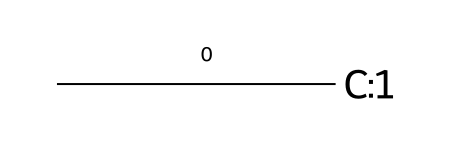

In [27]:
# parent_0 = "CC(C)c1cccc(c1O)C(C)C"
parent_0 = "CC"

parent_mol = Chem.MolFromSmiles(parent_0)
atom_idx(bond_idx(parent_mol))

In [28]:
list(enumerate(parent_mol.GetAtoms()))

[(0, <rdkit.Chem.rdchem.Atom at 0x2139f8dc760>),
 (1, <rdkit.Chem.rdchem.Atom at 0x2139f8dd9c0>)]

In [29]:
for j,bond in enumerate(parent_mol.GetBonds()):
    print(bond.GetBeginAtomIdx())
    print(bond.GetEndAtomIdx())

0
1


In [30]:
# for testing purposes (will not call dock_it())
generations=[[(parent_0,ran.uniform(-6,0))]]

# creates best_path list (top performers from each search), which will be of length depth+1, due to the parent molecule being the first entry
best_path=[generations[0][0]]

depth = 1

# Begin iterations
for gen in range(depth):
    # this is the temporarry array that will hold the molecules created throughout the editing process
    all_desc=[]
    # this defines the current parent as the best molecule from the previous iteration
    parent_smi=best_path[-1][0]
    parent_mol=Chem.MolFromSmiles(parent_smi)
    # Not sure what this line does specifically, but it is necessary so that the function degree() returns the proper bond counts.
    Chem.rdmolops.Kekulize(parent_mol,clearAromaticFlags=True)

    # Begin working through the molecular editing process - iterating through ATOMS
    for i,atom in enumerate(parent_mol.GetAtoms()):
        at_deg=degree(atom)
        atom_n=aname(atom)
        # checkpt
        #### Try to Mutate Atoms
        if at_deg == 4:#could be C or N
            if atom_n=="C":
                all_desc.append(mutate(parent_mol,atom,i,"N",1))#mutates atom in molecule to "N"
                check+=1
            if atom_n=="N":
                all_desc.append(mutate(parent_mol,atom,i,"C",0))   
        if at_deg == 3:#could be a C or N
            if atom_n=="C":
                all_desc.append(mutate(parent_mol,atom,i,"N",0))
                #all_desc.append(mutate(parent_mol,atom,i,"N",1))#could be protonated?
            if atom_n=="N":
                all_desc.append(mutate(parent_mol,atom,i,"C",0))
        if at_deg <=2: #could be a C or N or O
            if atom_n=="C":
                all_desc.append(mutate(parent_mol,atom,i,"N",0))
                #all_desc.append(mutate(parent_mol,atom,i,"N",1))#could be protonated?
                all_desc.append(mutate(parent_mol,atom,i,"O",0))
            if atom_n=="N":
                all_desc.append(mutate(parent_mol,atom,i,"C",0))
                all_desc.append(mutate(parent_mol,atom,i,"O",0))
            if atom_n=="O":
                all_desc.append(mutate(parent_mol,atom,i,"C",0))
                all_desc.append(mutate(parent_mol,atom,i,"N",0))
                #all_desc.append(mutate(parent_mol,atom,i,"N",1))#could be protonated?
                # if the atom is a halogen, it has degree of 1
            if atom_n in ["F","Cl"]:
                all_desc.append(mutate(parent_mol,atom,i,"C",0))
                all_desc.append(mutate(parent_mol,atom,i,"N",0))
                all_desc.append(mutate(parent_mol,atom,i,"O",0))
        if at_deg <= 1:
            all_desc.append(mutate(parent_mol,atom,i,"F",0))
            all_desc.append(mutate(parent_mol,atom,i,"Cl",0))
        

        
        #### Try to add a single atom w/ new atom bonded to the existing atom on molecule
        if at_deg == 3:# could be a C or N, could add a single bond C,N,or O
            #assume not an "O"
            if atom_n =="C":
                #FIX TO ALLOW N(-C)4, non-heteroatom quaternary nitrogen
                all_desc.append(add_single_bond(parent_mol,atom,i,"N"))#adds single bonded "N" to atom in molecule
                all_desc.append(add_single_bond(parent_mol,atom,i,"C"))
                all_desc.append(add_single_bond(parent_mol,atom,i,"O"))
                all_desc.append(add_single_bond(parent_mol,atom,i,"F"))
                all_desc.append(add_single_bond(parent_mol,atom,i,"Cl"))
        if at_deg ==2:# could be a C or N or O, but dont add to O
            if atom_n == "C":
                #add single bonded atom
                all_desc.append(add_single_bond(parent_mol,atom,i,"N"))
                all_desc.append(add_single_bond(parent_mol,atom,i,"C"))
                all_desc.append(add_single_bond(parent_mol,atom,i,"O"))
                all_desc.append(add_single_bond(parent_mol,atom,i,"F"))
                all_desc.append(add_single_bond(parent_mol,atom,i,"Cl"))
                #add double bonded atom but only if no double bond on c already
                if all([btype(bond)!="DOUBLE" for bond in atom.GetBonds()]):
                    all_desc.append(add_double_bond(parent_mol,atom,i,"N"))
                    all_desc.append(add_double_bond(parent_mol,atom,i,"C"))
                    all_desc.append(add_double_bond(parent_mol,atom,i,"O"))
            elif atom_n=="N":
                all_desc.append(add_single_bond(parent_mol,atom,i,"N"))
                all_desc.append(add_single_bond(parent_mol,atom,i,"C"))
        if at_deg <=1:# could be a C or N or O, but dont add double bond to O
            if atom_n == "C" :
                #add single bonded atom
                all_desc.append(add_single_bond(parent_mol,atom,i,"N"))
                all_desc.append(add_single_bond(parent_mol,atom,i,"C"))
                all_desc.append(add_single_bond(parent_mol,atom,i,"O"))
                all_desc.append(add_single_bond(parent_mol,atom,i,"F"))
                all_desc.append(add_single_bond(parent_mol,atom,i,"Cl"))
                #add double bonded atom
                all_desc.append(add_double_bond(parent_mol,atom,i,"N"))
                all_desc.append(add_double_bond(parent_mol,atom,i,"C"))
                all_desc.append(add_double_bond(parent_mol,atom,i,"O"))
                #add triple bonded atom
                all_desc.append(add_triple_bond(parent_mol,atom,i,"N"))
                all_desc.append(add_triple_bond(parent_mol,atom,i,"C"))
            elif atom_n =="N":
                all_desc.append(add_single_bond(parent_mol,atom,i,"N"))
                all_desc.append(add_single_bond(parent_mol,atom,i,"C"))
                all_desc.append(add_double_bond(parent_mol,atom,i,"C"))
            elif atom_n=="O":
                #add single bonded atom
                all_desc.append(add_single_bond(parent_mol,atom,i,"C"))
                all_desc.append(add_single_bond(parent_mol,atom,i,"O"))
        
        #### Try removing atom
        if at_deg==1:#no worries
            all_desc.append(remove_atom(parent_mol,atom,i))
        elif at_deg>=2:#only can remove if the resulting molecule is connected (doesn't have floating framents)
            tmp_mols=remove_atom(parent_mol,atom,i)
            tmp_mol=Chem.MolFromSmiles(tmp_mols)
            if check_connected(tmp_mol)==1:
                all_desc.append(tmp_mols)
        
    ### Begin iteration through BONDS
    for i,bond in enumerate(parent_mol.GetBonds()):
        # get the indices of the beginning and end atoms within the bond
        aidx1 = bond.GetBeginAtomIdx()
        aidx2 = bond.GetEndAtomIdx()
        #ignore bonds to halogens
        if parent_mol.GetAtoms()[aidx1].GetAtomicNum() not in halogens and parent_mol.GetAtoms()[aidx2].GetAtomicNum() not in halogens:
            #determine the names of elements in bond
            atom1=parent_mol.GetAtoms()[aidx1]
            atom2=parent_mol.GetAtoms()[aidx2]
            aname1=atomic_names[allowed_atomic.index(atom1.GetAtomicNum())]
            aname2=atomic_names[allowed_atomic.index(atom2.GetAtomicNum())]
            #determine degree of atoms in bond
            degree1=degree(parent_mol.GetAtoms()[aidx1])
            degree2=degree(parent_mol.GetAtoms()[aidx2])
            #check bond type and apply chemical rules
            if btype(bond) =="SINGLE":
                #check if not (between two double bonds and in ring)
                if not is_bet_dub_and_ring(parent_mol,bond):
                    #print(idone,bond)
                    #try making it a double bond
                    #print(i+1,is_aromatic(parent_mol,bond))
                    if (aname1 == "C") and (aname2 == "C"):#(aname1 == "C" or aname1 == "N") and (aname2 == "C" or aname2 == "N"):
                        if degree1<=3 and degree2<=3:#only two tertiary carbons can form a double bond (ignoring N+ )
                            all_desc.append(make_double(parent_mol,bond,i))
# On second though I don't think it is necessay to mutate atoms AND bonds... that's technically two chemical transformations
#                             # if one atom has degree of 2 or less, then bond mutations with N are possible
#                             if degree1<=2:
#                                 mutantN1 = Chem.MolFromSmiles(mutate(parent_mol,atom1,aidx1,"N",0))
#                                 all_desc.append(make_double(mutantN1,bond,i))
#                                 if degree1==1:
#                                     all_desc.append(make_triple(mutantN1,bond,i))
#                             elif degree2<=2:
#                                 mutantN2 = Chem.MolFromSmiles(mutate(parent_mol,atom2,aidx2,"N",0))
#                                 all_desc.append(make_double(mutantN2,bond,i))
#                                 if degree2==1:
#                                     all_desc.append(make_triple(mutant2,bond,i))
                    elif (aname1 == "O") and (aname2 == "C"):# a single bond with O-C
                        if degree1==1 and degree2<=3:#check if O is single degree and C is <terterary
                            all_desc.append(make_double(parent_mol,bond,i))# hydroxyl -> carbonyl
                    elif (aname1 == "C") and (aname2 == "O"):# a single bond with C-O
                        if degree1<=3 and degree2==1:#check if O is single degree and C is <terterary
                            all_desc.append(make_double(parent_mol,bond,i))# hydroxyl -> carbonyl      
                    elif aname1 == "C" and aname2 == "N":# a single bond with C-N
                        if degree1<=3 and degree2<=2:#check if N is 2 degree and C is <terterary
                            all_desc.append(make_double(parent_mol,bond,i))# 
                    elif aname1 == "N" and aname2 == "C":# a single bond with N-C
                        if degree1<=2 and degree2<=3:#check if N is 2 degree and C is <terterary
                            all_desc.append(make_double(parent_mol,bond,i))# 
                    #try making it a triple bond
                    #-C#N or -C#C or -C#C-
                    if (aname1 =="N" and degree1==1 and aname2=="C" and degree2<=2) or (aname1 =="C" and degree1<=2 and aname2=="N" and degree2==1) :# -C-N -> -C#N
                        all_desc.append(make_triple(parent_mol,bond,i))
                    elif aname1 =="C" and aname2=="C" and degree1<=2 and degree2<=2:
                        all_desc.append(make_triple(parent_mol,bond,i))
            elif btype(bond) =="DOUBLE":
                #try making a single bond, should be fine. but maybe diols are unlikely?
                all_desc.append(make_single(parent_mol,bond,i))
                #try making it a triple bond if not in ring
                if (aname1 == "C" or aname1 == "N") and (aname2 == "C" or aname2 == "N") and not (aname1 =="N" and aname2 == "N") and not bond.IsInRing():
                    if degree1<=3 and degree2<=3:
                        all_desc.append(make_triple(parent_mol,bond,i))
            elif btype(bond) =="TRIPLE":
                #try making a single bond
                all_desc.append(make_single(parent_mol,bond,i))
                #try making a double bond, it already was a triple, so should be fine
                all_desc.append(make_double(parent_mol,bond,i))
                #try removing the bond
            tmp_mols=remove_bond(parent_mol,aidx1,aidx2)
            tmp_mol=Chem.MolFromSmiles(tmp_mols)
            if check_connected(tmp_mol)==1:
                all_desc.append(tmp_mols)

In [36]:
master_set = [parent_0]
print(master_set)
list(dict.fromkeys(all_desc))
mset = set(master_list)

['CC']


In [8]:
# Keeping a set containing all UNIQUE molecules created and tested
master_set = list(dict.fromkeys([parent_0]))
# code to remove duplicate smile strings
all_set = list(dict.fromkeys(all_desc))
print(all_set)
mset = set(master_set)
# this returns the list of novel descendants that have not be created before (not in mset)
uniq_desc = [i for i in all_set if i not in mset]
print(uniq_desc)
master_set=master_set+uniq_desc
print(master_set)

['CN', 'CO', 'CF', 'CCl', 'CCN', 'CCC', 'CCO', 'CCF', 'CCCl', 'CC=N', 'C=CC', 'CC=O', 'CC#N', 'C#CC', 'C', 'C=C', 'C#C']
['CN', 'CO', 'CF', 'CCl', 'CCN', 'CCC', 'CCO', 'CCF', 'CCCl', 'CC=N', 'C=CC', 'CC=O', 'CC#N', 'C#CC', 'C', 'C=C', 'C#C']
['CC', 'CN', 'CO', 'CF', 'CCl', 'CCN', 'CCC', 'CCO', 'CCF', 'CCCl', 'CC=N', 'C=CC', 'CC=O', 'CC#N', 'C#CC', 'C', 'C=C', 'C#C']


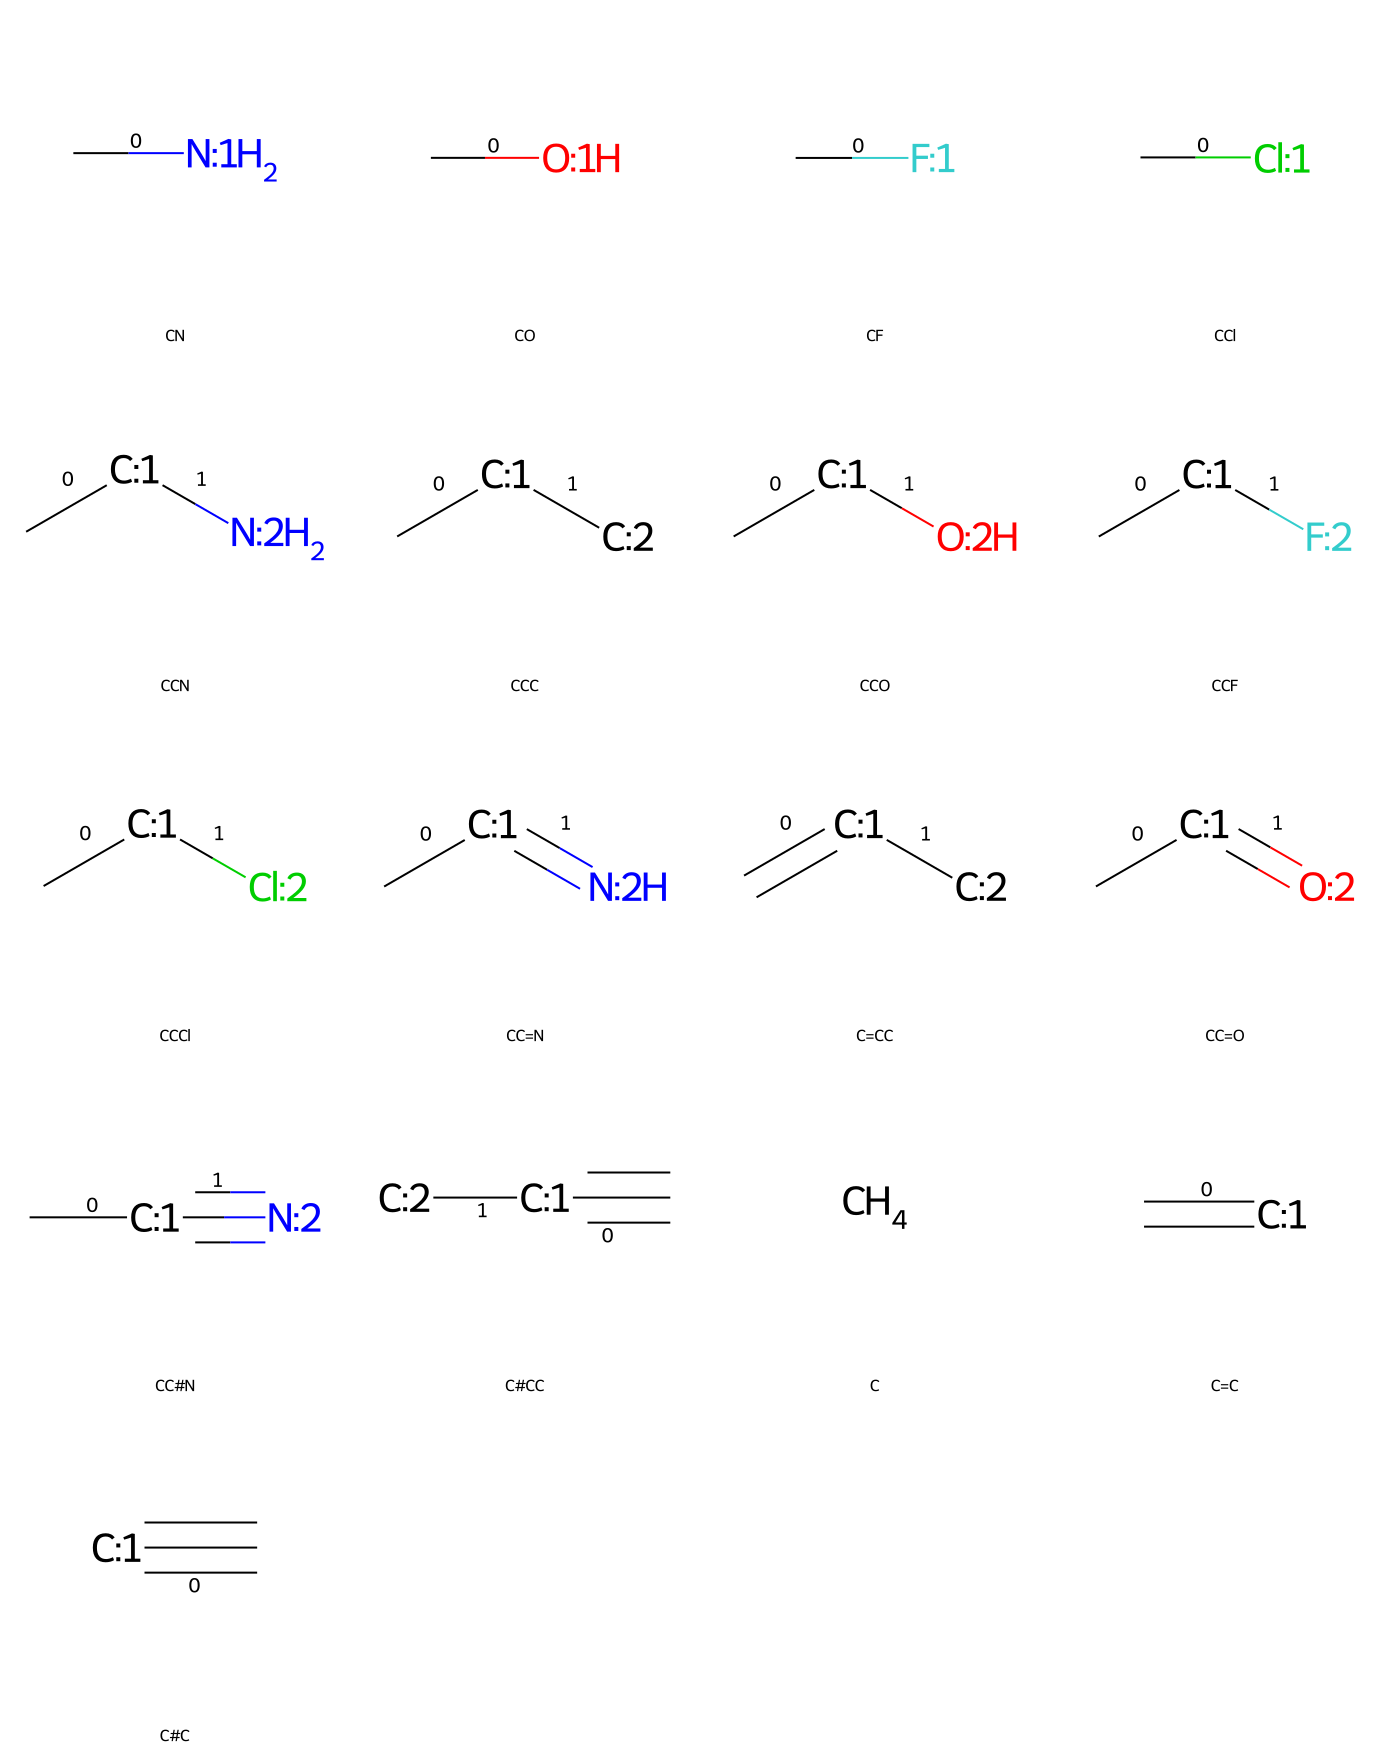

In [9]:
uniq_mols = []
for smi in uniq_desc:
    mol=Chem.MolFromSmiles(smi)
    Chem.rdmolops.Kekulize(mol,clearAromaticFlags=True)
    uniq_mols.append(atom_idx(bond_idx(mol)))
Draw.MolsToGridImage(uniq_mols,molsPerRow=4,subImgSize=(350,350),legends=[str(i) for i in uniq_desc])

# Making the molecular Gauntlet a FUNCTION (about time lol)

In [10]:
#####
### string parent_smi - the SMILE string of the parent molecule
### string list master_list - list of SMILE strings for all molecules that have been created so far (ordered)                                    
def nextGen(parent_smi,master_list):
    all_desc = []
    parent_mol=Chem.MolFromSmiles(parent_smi)
    # Not sure what this line does specifically, but it is necessary so that the function degree() returns the proper bond counts.
    Chem.rdmolops.Kekulize(parent_mol,clearAromaticFlags=True)

    # Begin working through the molecular editing process - iterating through ATOMS
    for i,atom in enumerate(parent_mol.GetAtoms()):
        at_deg=degree(atom)
        atom_n=aname(atom)
        # checkpt
        #### Try to Mutate Atoms
        if at_deg == 4:#could be C or N
            if atom_n=="C":
                all_desc.append(mutate(parent_mol,atom,i,"N",1))#mutates atom in molecule to "N"
                check+=1
            if atom_n=="N":
                all_desc.append(mutate(parent_mol,atom,i,"C",0))   
        if at_deg == 3:#could be a C or N
            if atom_n=="C":
                all_desc.append(mutate(parent_mol,atom,i,"N",0))
                #all_desc.append(mutate(parent_mol,atom,i,"N",1))#could be protonated?
            if atom_n=="N":
                all_desc.append(mutate(parent_mol,atom,i,"C",0))
        if at_deg <=2: #could be a C or N or O
            if atom_n=="C":
                all_desc.append(mutate(parent_mol,atom,i,"N",0))
                #all_desc.append(mutate(parent_mol,atom,i,"N",1))#could be protonated?
                all_desc.append(mutate(parent_mol,atom,i,"O",0))
            if atom_n=="N":
                all_desc.append(mutate(parent_mol,atom,i,"C",0))
                all_desc.append(mutate(parent_mol,atom,i,"O",0))
            if atom_n=="O":
                all_desc.append(mutate(parent_mol,atom,i,"C",0))
                all_desc.append(mutate(parent_mol,atom,i,"N",0))
                #all_desc.append(mutate(parent_mol,atom,i,"N",1))#could be protonated?
                # if the atom is a halogen, it has degree of 1
            if atom_n in ["F","Cl"]:
                all_desc.append(mutate(parent_mol,atom,i,"C",0))
                all_desc.append(mutate(parent_mol,atom,i,"N",0))
                all_desc.append(mutate(parent_mol,atom,i,"O",0))
        if at_deg <= 1:
            all_desc.append(mutate(parent_mol,atom,i,"F",0))
            all_desc.append(mutate(parent_mol,atom,i,"Cl",0))
        

        
        #### Try to add a single atom w/ new atom bonded to the existing atom on molecule
        if at_deg == 3:# could be a C or N, could add a single bond C,N,or O
            #assume not an "O"
            if atom_n =="C":
                #FIX TO ALLOW N(-C)4, non-heteroatom quaternary nitrogen
                all_desc.append(add_single_bond(parent_mol,atom,i,"N"))#adds single bonded "N" to atom in molecule
                all_desc.append(add_single_bond(parent_mol,atom,i,"C"))
                all_desc.append(add_single_bond(parent_mol,atom,i,"O"))
                all_desc.append(add_single_bond(parent_mol,atom,i,"F"))
                all_desc.append(add_single_bond(parent_mol,atom,i,"Cl"))
        if at_deg ==2:# could be a C or N or O, but dont add to O
            if atom_n == "C":
                #add single bonded atom
                all_desc.append(add_single_bond(parent_mol,atom,i,"N"))
                all_desc.append(add_single_bond(parent_mol,atom,i,"C"))
                all_desc.append(add_single_bond(parent_mol,atom,i,"O"))
                all_desc.append(add_single_bond(parent_mol,atom,i,"F"))
                all_desc.append(add_single_bond(parent_mol,atom,i,"Cl"))
                #add double bonded atom but only if no double bond on c already
                if all([btype(bond)!="DOUBLE" for bond in atom.GetBonds()]):
                    all_desc.append(add_double_bond(parent_mol,atom,i,"N"))
                    all_desc.append(add_double_bond(parent_mol,atom,i,"C"))
                    all_desc.append(add_double_bond(parent_mol,atom,i,"O"))
            elif atom_n=="N":
                all_desc.append(add_single_bond(parent_mol,atom,i,"N"))
                all_desc.append(add_single_bond(parent_mol,atom,i,"C"))
        if at_deg <=1:# could be a C or N or O, but dont add double bond to O
            if atom_n == "C" :
                #add single bonded atom
                all_desc.append(add_single_bond(parent_mol,atom,i,"N"))
                all_desc.append(add_single_bond(parent_mol,atom,i,"C"))
                all_desc.append(add_single_bond(parent_mol,atom,i,"O"))
                all_desc.append(add_single_bond(parent_mol,atom,i,"F"))
                all_desc.append(add_single_bond(parent_mol,atom,i,"Cl"))
                #add double bonded atom
                all_desc.append(add_double_bond(parent_mol,atom,i,"N"))
                all_desc.append(add_double_bond(parent_mol,atom,i,"C"))
                all_desc.append(add_double_bond(parent_mol,atom,i,"O"))
                #add triple bonded atom
                all_desc.append(add_triple_bond(parent_mol,atom,i,"N"))
                all_desc.append(add_triple_bond(parent_mol,atom,i,"C"))
            elif atom_n =="N":
                all_desc.append(add_single_bond(parent_mol,atom,i,"N"))
                all_desc.append(add_single_bond(parent_mol,atom,i,"C"))
                all_desc.append(add_double_bond(parent_mol,atom,i,"C"))
            elif atom_n=="O":
                #add single bonded atom
                all_desc.append(add_single_bond(parent_mol,atom,i,"C"))
                all_desc.append(add_single_bond(parent_mol,atom,i,"O"))
        
        #### Try removing atom
        if at_deg==1:#no worries
            all_desc.append(remove_atom(parent_mol,atom,i))
        elif at_deg>=2:#only can remove if the resulting molecule is connected (doesn't have floating framents)
            tmp_mols=remove_atom(parent_mol,atom,i)
            tmp_mol=Chem.MolFromSmiles(tmp_mols)
            if check_connected(tmp_mol)==1:
                all_desc.append(tmp_mols)
        
    ### Begin iteration through BONDS
    for i,bond in enumerate(parent_mol.GetBonds()):
        # get the indices of the beginning and end atoms within the bond
        aidx1 = bond.GetBeginAtomIdx()
        aidx2 = bond.GetEndAtomIdx()
        #ignore bonds to halogens
        if parent_mol.GetAtoms()[aidx1].GetAtomicNum() not in halogens and parent_mol.GetAtoms()[aidx2].GetAtomicNum() not in halogens:
            #determine the names of elements in bond
            atom1=parent_mol.GetAtoms()[aidx1]
            atom2=parent_mol.GetAtoms()[aidx2]
            aname1=atomic_names[allowed_atomic.index(atom1.GetAtomicNum())]
            aname2=atomic_names[allowed_atomic.index(atom2.GetAtomicNum())]
            #determine degree of atoms in bond
            degree1=degree(parent_mol.GetAtoms()[aidx1])
            degree2=degree(parent_mol.GetAtoms()[aidx2])
            #check bond type and apply chemical rules
            if btype(bond) =="SINGLE":
                #check if not (between two double bonds and in ring)
                if not is_bet_dub_and_ring(parent_mol,bond):
                    #print(idone,bond)
                    #try making it a double bond
                    #print(i+1,is_aromatic(parent_mol,bond))
                    if (aname1 == "C") and (aname2 == "C"):#(aname1 == "C" or aname1 == "N") and (aname2 == "C" or aname2 == "N"):
                        if degree1<=3 and degree2<=3:#only two tertiary carbons can form a double bond (ignoring N+ )
                            all_desc.append(make_double(parent_mol,bond,i))
# On second though I don't think it is necessay to mutate atoms AND bonds... that's technically two chemical transformations
#                             # if one atom has degree of 2 or less, then bond mutations with N are possible
#                             if degree1<=2:
#                                 mutantN1 = Chem.MolFromSmiles(mutate(parent_mol,atom1,aidx1,"N",0))
#                                 all_desc.append(make_double(mutantN1,bond,i))
#                                 if degree1==1:
#                                     all_desc.append(make_triple(mutantN1,bond,i))
#                             elif degree2<=2:
#                                 mutantN2 = Chem.MolFromSmiles(mutate(parent_mol,atom2,aidx2,"N",0))
#                                 all_desc.append(make_double(mutantN2,bond,i))
#                                 if degree2==1:
#                                     all_desc.append(make_triple(mutant2,bond,i))
                    elif (aname1 == "O") and (aname2 == "C"):# a single bond with O-C
                        if degree1==1 and degree2<=3:#check if O is single degree and C is <terterary
                            all_desc.append(make_double(parent_mol,bond,i))# hydroxyl -> carbonyl
                    elif (aname1 == "C") and (aname2 == "O"):# a single bond with C-O
                        if degree1<=3 and degree2==1:#check if O is single degree and C is <terterary
                            all_desc.append(make_double(parent_mol,bond,i))# hydroxyl -> carbonyl      
                    elif aname1 == "C" and aname2 == "N":# a single bond with C-N
                        if degree1<=3 and degree2<=2:#check if N is 2 degree and C is <terterary
                            all_desc.append(make_double(parent_mol,bond,i))# 
                    elif aname1 == "N" and aname2 == "C":# a single bond with N-C
                        if degree1<=2 and degree2<=3:#check if N is 2 degree and C is <terterary
                            all_desc.append(make_double(parent_mol,bond,i))# 
                    #try making it a triple bond
                    #-C#N or -C#C or -C#C-
                    if (aname1 =="N" and degree1==1 and aname2=="C" and degree2<=2) or (aname1 =="C" and degree1<=2 and aname2=="N" and degree2==1) :# -C-N -> -C#N
                        all_desc.append(make_triple(parent_mol,bond,i))
                    elif aname1 =="C" and aname2=="C" and degree1<=2 and degree2<=2:
                        all_desc.append(make_triple(parent_mol,bond,i))
            elif btype(bond) =="DOUBLE":
                #try making a single bond, should be fine. but maybe diols are unlikely?
                all_desc.append(make_single(parent_mol,bond,i))
                #try making it a triple bond if not in ring
                if (aname1 == "C" or aname1 == "N") and (aname2 == "C" or aname2 == "N") and not (aname1 =="N" and aname2 == "N") and not bond.IsInRing():
                    if degree1<=3 and degree2<=3:
                        all_desc.append(make_triple(parent_mol,bond,i))
            elif btype(bond) =="TRIPLE":
                #try making a single bond
                all_desc.append(make_single(parent_mol,bond,i))
                #try making a double bond, it already was a triple, so should be fine
                all_desc.append(make_double(parent_mol,bond,i))
                #try removing the bond
            tmp_mols=remove_bond(parent_mol,aidx1,aidx2)
            tmp_mol=Chem.MolFromSmiles(tmp_mols)
            if check_connected(tmp_mol)==1:
                all_desc.append(tmp_mols)
    
    # code to remove duplicate smile strings
    all_set = list(dict.fromkeys(all_desc)) # this removes duplicates but saves relative order
    mset = set(master_list)
    uniq_desc = [i for i in all_set if i not in mset]
    master_list=master_list+uniq_desc
    return all_set, master_list

In [20]:
parent_0="CC"
master_list = [parent_0]
neighbors1, master_list = nextGen(parent_0, master_list)
print(neighbors1)
print(master_list)

['CN', 'CO', 'CF', 'CCl', 'CCN', 'CCC', 'CCO', 'CCF', 'CCCl', 'CC=N', 'C=CC', 'CC=O', 'CC#N', 'C#CC', 'C', 'C=C', 'C#C']
['CC', 'CN', 'CO', 'CF', 'CCl', 'CCN', 'CCC', 'CCO', 'CCF', 'CCCl', 'CC=N', 'C=CC', 'CC=O', 'CC#N', 'C#CC', 'C', 'C=C', 'C#C']


In [23]:
dict.fromkeys([parent_0, "CC"])

{'CC': None}

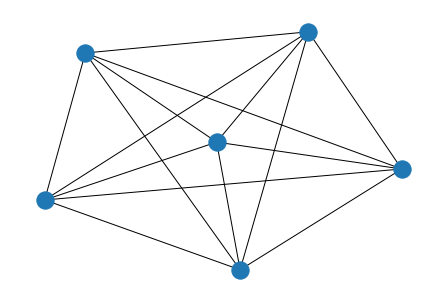

In [12]:
import networkx as nx
G = nx.complete_graph(6)
nx.draw(G)

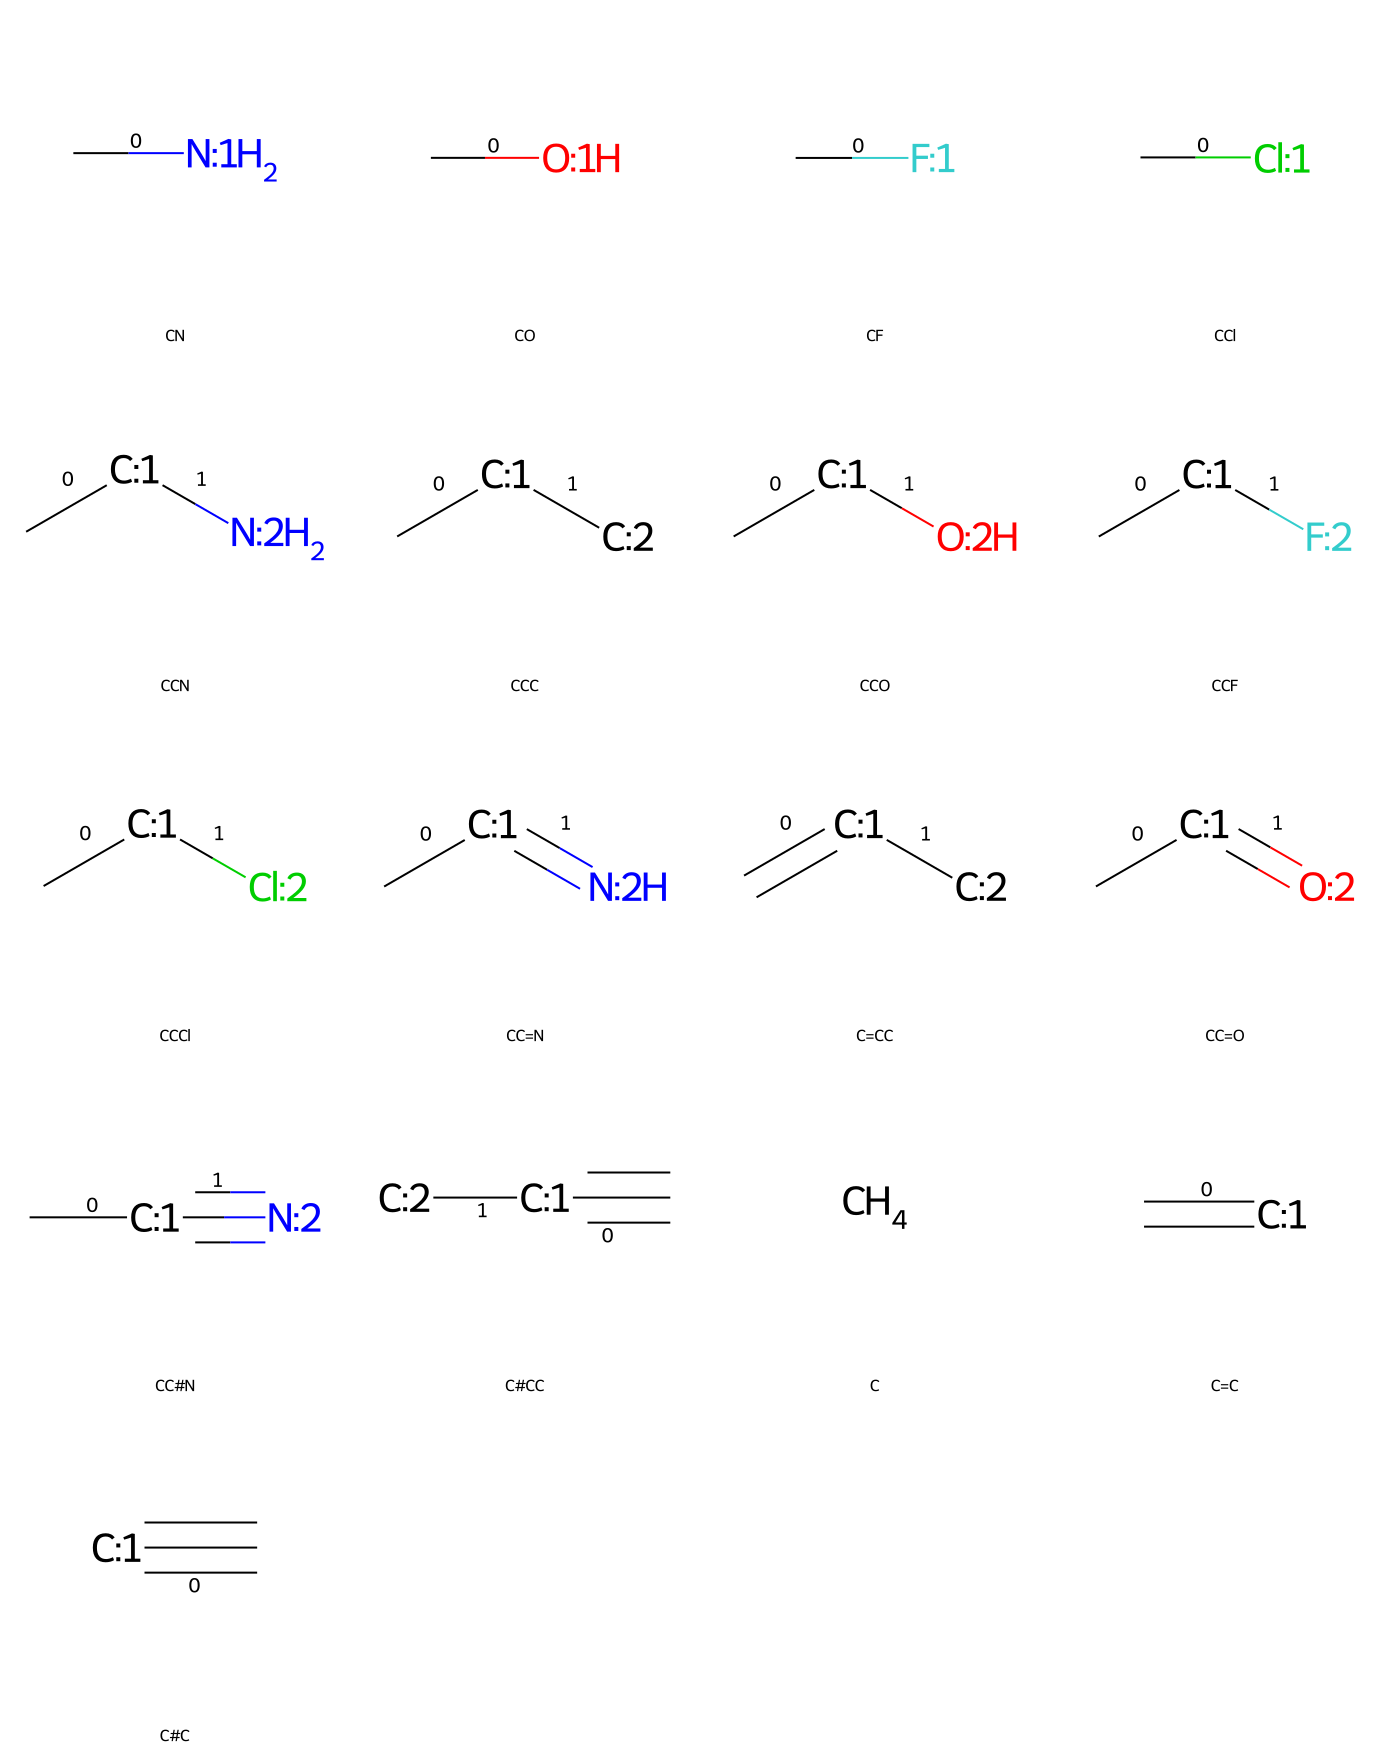

In [13]:
uniq_mols = []
for smi in uniq_desc:
    mol=Chem.MolFromSmiles(smi)
    Chem.rdmolops.Kekulize(mol,clearAromaticFlags=True)
    uniq_mols.append(atom_idx(bond_idx(mol)))
Draw.MolsToGridImage(uniq_mols,molsPerRow=4,subImgSize=(350,350),legends=[str(i) for i in uniq_desc])

In [14]:
import tmap as tm
import numpy as np
from matplotlib import pyplot as plt

n = 25
edge_list = []

# Create a random graph
for i in range(n):
    for j in np.random.randint(0, high=n, size=2):
        edge_list.append([i, j, np.random.rand(1)])

# Compute the layout
x, y, s, t, _ = tm.layout_from_edge_list(
    n, edge_list, create_mst=False
)

# Plot the edges
for i in range(len(s)):
    plt.plot(
        [x[s[i]], x[t[i]]],
        [y[s[i]], y[t[i]]],
        "k-",
        linewidth=0.5,
        alpha=0.5,
        zorder=1,
    )

# Plot the vertices
plt.scatter(x, y, zorder=2)
plt.tight_layout()
plt.savefig("simple_graph.png")



AttributeError: module 'tmap' has no attribute 'layout_from_edge_list'